<a href="https://colab.research.google.com/github/Aldrin-Fanir/Hippocampal-Region-Segmentation-UNet/blob/main/HippocampalRegionUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [ ]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Drive Mount: Import Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Directory of Images and Masks

In [ ]:
root_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/Cohort1-Multiplexed Dataset'

In [ ]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Hippocampal Region Dataset

In [ ]:
class HippocampalDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/cFos_NeuN_dFos_dataset_images/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_images")])[: self.limit]
    self.masks = sorted([root_path + "/cFos_NeuN_dFos_dataset_masks/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_masks")])[: self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)

  def __len__(self):
    return min(len(self.images), self.limit)


# Create Model

# Double Convolution

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [ ]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [ ]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size = 2, stride = 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 32)
    self.down_convolution_2 = DownSample(32, 64)
    self.down_convolution_3 = DownSample(64, 128)
    #self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(128, 256)

    self.up_convolution_1 = UpSample(256, 128)
    self.up_convolution_2 = UpSample(128, 64)
    self.up_convolution_3 = UpSample(64, 32)
    #self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(32, out_channels = num_classes, kernel_size = 1)



  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    #down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p3)

    up_1 = self.up_convolution_1(b, down_3)
    up_2 = self.up_convolution_2(up_1, down_2)
    up_3 = self.up_convolution_3(up_2, down_1)
    #up_4 = self.up_convolution_4(up_3, down_1)

    return self.output(up_3)

# Trainning The Model

In [ ]:
train_dataset = HippocampalDataset(root_path)
generator = torch.Generator().manual_seed(42)

In [ ]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [ ]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator = generator)

**Running this experiment with CUDA**

In [ ]:
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup out model using the AdamW optimizer and the BCEWithLogitsLoss**

In [ ]:
Learning_Rate = 1e-4
batch_size = 4

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)

model = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr = Learning_Rate)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

239
30
29


**Evaluating Segmentation Performance with DICEMetric**

In [ ]:
def dice_coefficient(prediction, target, epsilon = 1e-7):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = torch.sum(prediction_copy) + torch.sum(target)
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice

In [ ]:
torch.cuda.empty_cache()

# Training

In [ ]:
epochs = 100
train_losses = []
train_dcs = []

val_losses = []
val_dcs = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_running_loss = 0
  traing_running_dc = 0

  for idx, img_mask in enumerate(tqdm(train_dataloader, position = 0, leave=True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = model(img)
    optimizer.zero_grad()

    dc = dice_coefficient(y_pred, mask)
    loss = criterion(y_pred, mask)

    train_running_loss += loss.item()
    traing_running_dc += dc.item()

    loss.backward()
    optimizer.step()

  train_loss = train_running_loss/(idx + 1)
  train_dc = traing_running_dc/(idx + 1)

  train_losses.append(train_loss)
  train_dcs.append(train_dc)




  model.eval()
  val_running_loss = 0
  val_running_dc = 0

  with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave = True)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      loss = criterion(y_pred , mask)
      dc = dice_coefficient(y_pred, mask)

      val_running_loss += loss.item()
      val_running_dc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

  val_losses.append(val_loss)
  val_dcs.append(val_dc)



  print("-" * 30)
  print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
  print("\n")
  print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
  print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
  print("-" * 30)

  1%|          | 1/100 [00:04<07:36,  4.61s/it]

------------------------------
Training Loss EPOCH 1: 0.6341
Training DICE EPOCH 1: 0.1078


Validation Loss EPOCH 1: 0.3632
Validation DICE EPOCH 1: 0.0000
------------------------------


  2%|▏         | 2/100 [00:08<07:13,  4.42s/it]

------------------------------
Training Loss EPOCH 2: 0.3260
Training DICE EPOCH 2: 0.0000


Validation Loss EPOCH 2: 0.2833
Validation DICE EPOCH 2: 0.0000
------------------------------


  3%|▎         | 3/100 [00:13<06:55,  4.28s/it]

------------------------------
Training Loss EPOCH 3: 0.2667
Training DICE EPOCH 3: 0.0000


Validation Loss EPOCH 3: 0.2328
Validation DICE EPOCH 3: 0.0001
------------------------------


  4%|▍         | 4/100 [00:17<06:49,  4.26s/it]

------------------------------
Training Loss EPOCH 4: 0.2212
Training DICE EPOCH 4: 0.1687


Validation Loss EPOCH 4: 0.1902
Validation DICE EPOCH 4: 0.5059
------------------------------


  5%|▌         | 5/100 [00:21<06:48,  4.30s/it]

------------------------------
Training Loss EPOCH 5: 0.2020
Training DICE EPOCH 5: 0.5110


Validation Loss EPOCH 5: 0.2188
Validation DICE EPOCH 5: 0.5236
------------------------------


  6%|▌         | 6/100 [00:25<06:39,  4.25s/it]

------------------------------
Training Loss EPOCH 6: 0.2034
Training DICE EPOCH 6: 0.4908


Validation Loss EPOCH 6: 0.1757
Validation DICE EPOCH 6: 0.5855
------------------------------


  7%|▋         | 7/100 [00:29<06:31,  4.21s/it]

------------------------------
Training Loss EPOCH 7: 0.1910
Training DICE EPOCH 7: 0.5535


Validation Loss EPOCH 7: 0.1771
Validation DICE EPOCH 7: 0.5782
------------------------------


  8%|▊         | 8/100 [00:34<06:31,  4.25s/it]

------------------------------
Training Loss EPOCH 8: 0.1902
Training DICE EPOCH 8: 0.5417


Validation Loss EPOCH 8: 0.1780
Validation DICE EPOCH 8: 0.6141
------------------------------


  9%|▉         | 9/100 [00:38<06:24,  4.22s/it]

------------------------------
Training Loss EPOCH 9: 0.1850
Training DICE EPOCH 9: 0.5635


Validation Loss EPOCH 9: 0.1726
Validation DICE EPOCH 9: 0.6213
------------------------------


 10%|█         | 10/100 [00:42<06:19,  4.22s/it]

------------------------------
Training Loss EPOCH 10: 0.1829
Training DICE EPOCH 10: 0.5565


Validation Loss EPOCH 10: 0.1583
Validation DICE EPOCH 10: 0.6513
------------------------------


 11%|█         | 11/100 [00:46<06:17,  4.24s/it]

------------------------------
Training Loss EPOCH 11: 0.1778
Training DICE EPOCH 11: 0.5692


Validation Loss EPOCH 11: 0.1619
Validation DICE EPOCH 11: 0.6640
------------------------------


 12%|█▏        | 12/100 [00:51<06:11,  4.22s/it]

------------------------------
Training Loss EPOCH 12: 0.1747
Training DICE EPOCH 12: 0.5713


Validation Loss EPOCH 12: 0.1542
Validation DICE EPOCH 12: 0.6641
------------------------------


 13%|█▎        | 13/100 [00:55<06:07,  4.22s/it]

------------------------------
Training Loss EPOCH 13: 0.1700
Training DICE EPOCH 13: 0.5876


Validation Loss EPOCH 13: 0.1509
Validation DICE EPOCH 13: 0.6519
------------------------------


 14%|█▍        | 14/100 [00:59<06:04,  4.24s/it]

------------------------------
Training Loss EPOCH 14: 0.1677
Training DICE EPOCH 14: 0.5939


Validation Loss EPOCH 14: 0.1517
Validation DICE EPOCH 14: 0.6230
------------------------------


 15%|█▌        | 15/100 [01:03<06:00,  4.24s/it]

------------------------------
Training Loss EPOCH 15: 0.1676
Training DICE EPOCH 15: 0.5860


Validation Loss EPOCH 15: 0.1462
Validation DICE EPOCH 15: 0.6448
------------------------------


 16%|█▌        | 16/100 [01:07<05:53,  4.21s/it]

------------------------------
Training Loss EPOCH 16: 0.1679
Training DICE EPOCH 16: 0.5924


Validation Loss EPOCH 16: 0.1527
Validation DICE EPOCH 16: 0.6569
------------------------------


 17%|█▋        | 17/100 [01:12<05:52,  4.25s/it]

------------------------------
Training Loss EPOCH 17: 0.1670
Training DICE EPOCH 17: 0.5781


Validation Loss EPOCH 17: 0.1466
Validation DICE EPOCH 17: 0.6579
------------------------------


 18%|█▊        | 18/100 [01:16<05:45,  4.21s/it]

------------------------------
Training Loss EPOCH 18: 0.1619
Training DICE EPOCH 18: 0.6134


Validation Loss EPOCH 18: 0.1437
Validation DICE EPOCH 18: 0.6213
------------------------------


 19%|█▉        | 19/100 [01:20<05:41,  4.22s/it]

------------------------------
Training Loss EPOCH 19: 0.1619
Training DICE EPOCH 19: 0.6046


Validation Loss EPOCH 19: 0.1445
Validation DICE EPOCH 19: 0.6192
------------------------------


 20%|██        | 20/100 [01:24<05:37,  4.22s/it]

------------------------------
Training Loss EPOCH 20: 0.1625
Training DICE EPOCH 20: 0.5875


Validation Loss EPOCH 20: 0.1469
Validation DICE EPOCH 20: 0.6622
------------------------------


 21%|██        | 21/100 [01:29<05:32,  4.20s/it]

------------------------------
Training Loss EPOCH 21: 0.1636
Training DICE EPOCH 21: 0.6077


Validation Loss EPOCH 21: 0.1462
Validation DICE EPOCH 21: 0.6488
------------------------------


 22%|██▏       | 22/100 [01:33<05:28,  4.21s/it]

------------------------------
Training Loss EPOCH 22: 0.1598
Training DICE EPOCH 22: 0.6099


Validation Loss EPOCH 22: 0.1400
Validation DICE EPOCH 22: 0.6632
------------------------------


 23%|██▎       | 23/100 [01:37<05:23,  4.20s/it]

------------------------------
Training Loss EPOCH 23: 0.1589
Training DICE EPOCH 23: 0.6194


Validation Loss EPOCH 23: 0.1483
Validation DICE EPOCH 23: 0.6264
------------------------------


 24%|██▍       | 24/100 [01:41<05:18,  4.19s/it]

------------------------------
Training Loss EPOCH 24: 0.1615
Training DICE EPOCH 24: 0.6139


Validation Loss EPOCH 24: 0.1460
Validation DICE EPOCH 24: 0.6829
------------------------------


 25%|██▌       | 25/100 [01:45<05:17,  4.23s/it]

------------------------------
Training Loss EPOCH 25: 0.1571
Training DICE EPOCH 25: 0.6278


Validation Loss EPOCH 25: 0.1422
Validation DICE EPOCH 25: 0.6722
------------------------------


 26%|██▌       | 26/100 [01:50<05:12,  4.22s/it]

------------------------------
Training Loss EPOCH 26: 0.1570
Training DICE EPOCH 26: 0.6335


Validation Loss EPOCH 26: 0.1369
Validation DICE EPOCH 26: 0.6651
------------------------------


 27%|██▋       | 27/100 [01:54<05:06,  4.19s/it]

------------------------------
Training Loss EPOCH 27: 0.1574
Training DICE EPOCH 27: 0.6250


Validation Loss EPOCH 27: 0.1442
Validation DICE EPOCH 27: 0.6840
------------------------------


 28%|██▊       | 28/100 [01:58<05:05,  4.25s/it]

------------------------------
Training Loss EPOCH 28: 0.1540
Training DICE EPOCH 28: 0.6416


Validation Loss EPOCH 28: 0.1406
Validation DICE EPOCH 28: 0.6716
------------------------------


 29%|██▉       | 29/100 [02:02<05:01,  4.24s/it]

------------------------------
Training Loss EPOCH 29: 0.1525
Training DICE EPOCH 29: 0.6418


Validation Loss EPOCH 29: 0.1476
Validation DICE EPOCH 29: 0.6984
------------------------------


 30%|███       | 30/100 [02:07<04:55,  4.22s/it]

------------------------------
Training Loss EPOCH 30: 0.1559
Training DICE EPOCH 30: 0.6225


Validation Loss EPOCH 30: 0.1448
Validation DICE EPOCH 30: 0.6837
------------------------------


 31%|███       | 31/100 [02:11<04:52,  4.24s/it]

------------------------------
Training Loss EPOCH 31: 0.1548
Training DICE EPOCH 31: 0.6317


Validation Loss EPOCH 31: 0.1471
Validation DICE EPOCH 31: 0.6500
------------------------------


 32%|███▏      | 32/100 [02:15<04:47,  4.22s/it]

------------------------------
Training Loss EPOCH 32: 0.1542
Training DICE EPOCH 32: 0.6320


Validation Loss EPOCH 32: 0.1381
Validation DICE EPOCH 32: 0.6985
------------------------------


 33%|███▎      | 33/100 [02:19<04:41,  4.19s/it]

------------------------------
Training Loss EPOCH 33: 0.1518
Training DICE EPOCH 33: 0.6536


Validation Loss EPOCH 33: 0.1429
Validation DICE EPOCH 33: 0.6899
------------------------------


 34%|███▍      | 34/100 [02:23<04:38,  4.22s/it]

------------------------------
Training Loss EPOCH 34: 0.1501
Training DICE EPOCH 34: 0.6537


Validation Loss EPOCH 34: 0.1432
Validation DICE EPOCH 34: 0.6068
------------------------------


 35%|███▌      | 35/100 [02:28<04:33,  4.21s/it]

------------------------------
Training Loss EPOCH 35: 0.1499
Training DICE EPOCH 35: 0.6528


Validation Loss EPOCH 35: 0.1370
Validation DICE EPOCH 35: 0.6698
------------------------------


 36%|███▌      | 36/100 [02:32<04:29,  4.21s/it]

------------------------------
Training Loss EPOCH 36: 0.1477
Training DICE EPOCH 36: 0.6568


Validation Loss EPOCH 36: 0.1375
Validation DICE EPOCH 36: 0.6662
------------------------------


 37%|███▋      | 37/100 [02:36<04:27,  4.25s/it]

------------------------------
Training Loss EPOCH 37: 0.1470
Training DICE EPOCH 37: 0.6667


Validation Loss EPOCH 37: 0.1359
Validation DICE EPOCH 37: 0.6676
------------------------------


 38%|███▊      | 38/100 [02:40<04:22,  4.23s/it]

------------------------------
Training Loss EPOCH 38: 0.1443
Training DICE EPOCH 38: 0.6674


Validation Loss EPOCH 38: 0.1399
Validation DICE EPOCH 38: 0.6912
------------------------------


 39%|███▉      | 39/100 [02:44<04:16,  4.20s/it]

------------------------------
Training Loss EPOCH 39: 0.1446
Training DICE EPOCH 39: 0.6669


Validation Loss EPOCH 39: 0.1355
Validation DICE EPOCH 39: 0.6586
------------------------------


 40%|████      | 40/100 [02:49<04:14,  4.24s/it]

------------------------------
Training Loss EPOCH 40: 0.1422
Training DICE EPOCH 40: 0.6644


Validation Loss EPOCH 40: 0.1385
Validation DICE EPOCH 40: 0.6487
------------------------------


 41%|████      | 41/100 [02:53<04:08,  4.20s/it]

------------------------------
Training Loss EPOCH 41: 0.1403
Training DICE EPOCH 41: 0.6737


Validation Loss EPOCH 41: 0.1346
Validation DICE EPOCH 41: 0.7050
------------------------------


 42%|████▏     | 42/100 [02:57<04:02,  4.18s/it]

------------------------------
Training Loss EPOCH 42: 0.1397
Training DICE EPOCH 42: 0.6787


Validation Loss EPOCH 42: 0.1416
Validation DICE EPOCH 42: 0.6988
------------------------------


 43%|████▎     | 43/100 [03:01<04:00,  4.22s/it]

------------------------------
Training Loss EPOCH 43: 0.1447
Training DICE EPOCH 43: 0.6602


Validation Loss EPOCH 43: 0.1367
Validation DICE EPOCH 43: 0.6481
------------------------------


 44%|████▍     | 44/100 [03:06<03:55,  4.20s/it]

------------------------------
Training Loss EPOCH 44: 0.1489
Training DICE EPOCH 44: 0.6464


Validation Loss EPOCH 44: 0.1355
Validation DICE EPOCH 44: 0.6695
------------------------------


 45%|████▌     | 45/100 [03:10<03:50,  4.20s/it]

------------------------------
Training Loss EPOCH 45: 0.1382
Training DICE EPOCH 45: 0.6801


Validation Loss EPOCH 45: 0.1379
Validation DICE EPOCH 45: 0.6641
------------------------------


 46%|████▌     | 46/100 [03:14<03:48,  4.23s/it]

------------------------------
Training Loss EPOCH 46: 0.1367
Training DICE EPOCH 46: 0.6914


Validation Loss EPOCH 46: 0.1328
Validation DICE EPOCH 46: 0.7059
------------------------------


 47%|████▋     | 47/100 [03:18<03:43,  4.21s/it]

------------------------------
Training Loss EPOCH 47: 0.1339
Training DICE EPOCH 47: 0.6935


Validation Loss EPOCH 47: 0.1335
Validation DICE EPOCH 47: 0.7029
------------------------------


 48%|████▊     | 48/100 [03:22<03:38,  4.20s/it]

------------------------------
Training Loss EPOCH 48: 0.1317
Training DICE EPOCH 48: 0.6946


Validation Loss EPOCH 48: 0.1327
Validation DICE EPOCH 48: 0.7150
------------------------------


 49%|████▉     | 49/100 [03:27<03:34,  4.21s/it]

------------------------------
Training Loss EPOCH 49: 0.1301
Training DICE EPOCH 49: 0.6998


Validation Loss EPOCH 49: 0.1444
Validation DICE EPOCH 49: 0.7128
------------------------------


 50%|█████     | 50/100 [03:31<03:30,  4.22s/it]

------------------------------
Training Loss EPOCH 50: 0.1312
Training DICE EPOCH 50: 0.6949


Validation Loss EPOCH 50: 0.1349
Validation DICE EPOCH 50: 0.7124
------------------------------


 51%|█████     | 51/100 [03:35<03:26,  4.21s/it]

------------------------------
Training Loss EPOCH 51: 0.1349
Training DICE EPOCH 51: 0.6844


Validation Loss EPOCH 51: 0.1292
Validation DICE EPOCH 51: 0.7083
------------------------------


 52%|█████▏    | 52/100 [03:39<03:23,  4.23s/it]

------------------------------
Training Loss EPOCH 52: 0.1268
Training DICE EPOCH 52: 0.7052


Validation Loss EPOCH 52: 0.1361
Validation DICE EPOCH 52: 0.7203
------------------------------


 53%|█████▎    | 53/100 [03:44<03:18,  4.23s/it]

------------------------------
Training Loss EPOCH 53: 0.1252
Training DICE EPOCH 53: 0.7139


Validation Loss EPOCH 53: 0.1306
Validation DICE EPOCH 53: 0.6636
------------------------------


 54%|█████▍    | 54/100 [03:48<03:14,  4.23s/it]

------------------------------
Training Loss EPOCH 54: 0.1243
Training DICE EPOCH 54: 0.7113


Validation Loss EPOCH 54: 0.1338
Validation DICE EPOCH 54: 0.6441
------------------------------


 55%|█████▌    | 55/100 [03:52<03:09,  4.21s/it]

------------------------------
Training Loss EPOCH 55: 0.1251
Training DICE EPOCH 55: 0.7061


Validation Loss EPOCH 55: 0.1323
Validation DICE EPOCH 55: 0.7267
------------------------------


 56%|█████▌    | 56/100 [03:56<03:03,  4.18s/it]

------------------------------
Training Loss EPOCH 56: 0.1261
Training DICE EPOCH 56: 0.7098


Validation Loss EPOCH 56: 0.1283
Validation DICE EPOCH 56: 0.7205
------------------------------


 57%|█████▋    | 57/100 [04:00<03:01,  4.22s/it]

------------------------------
Training Loss EPOCH 57: 0.1199
Training DICE EPOCH 57: 0.7214


Validation Loss EPOCH 57: 0.1365
Validation DICE EPOCH 57: 0.7237
------------------------------


 58%|█████▊    | 58/100 [04:05<02:56,  4.21s/it]

------------------------------
Training Loss EPOCH 58: 0.1179
Training DICE EPOCH 58: 0.7232


Validation Loss EPOCH 58: 0.1295
Validation DICE EPOCH 58: 0.7244
------------------------------


 59%|█████▉    | 59/100 [04:09<02:52,  4.22s/it]

------------------------------
Training Loss EPOCH 59: 0.1173
Training DICE EPOCH 59: 0.7337


Validation Loss EPOCH 59: 0.1274
Validation DICE EPOCH 59: 0.7145
------------------------------


 60%|██████    | 60/100 [04:13<02:49,  4.24s/it]

------------------------------
Training Loss EPOCH 60: 0.1201
Training DICE EPOCH 60: 0.7239


Validation Loss EPOCH 60: 0.1269
Validation DICE EPOCH 60: 0.7240
------------------------------


 61%|██████    | 61/100 [04:17<02:44,  4.22s/it]

------------------------------
Training Loss EPOCH 61: 0.1145
Training DICE EPOCH 61: 0.7403


Validation Loss EPOCH 61: 0.1357
Validation DICE EPOCH 61: 0.7185
------------------------------


 62%|██████▏   | 62/100 [04:21<02:40,  4.22s/it]

------------------------------
Training Loss EPOCH 62: 0.1185
Training DICE EPOCH 62: 0.7324


Validation Loss EPOCH 62: 0.1261
Validation DICE EPOCH 62: 0.7018
------------------------------


 63%|██████▎   | 63/100 [04:26<02:37,  4.25s/it]

------------------------------
Training Loss EPOCH 63: 0.1150
Training DICE EPOCH 63: 0.7408


Validation Loss EPOCH 63: 0.1275
Validation DICE EPOCH 63: 0.7302
------------------------------


 64%|██████▍   | 64/100 [04:30<02:31,  4.22s/it]

------------------------------
Training Loss EPOCH 64: 0.1157
Training DICE EPOCH 64: 0.7321


Validation Loss EPOCH 64: 0.1255
Validation DICE EPOCH 64: 0.7042
------------------------------


 65%|██████▌   | 65/100 [04:34<02:27,  4.22s/it]

------------------------------
Training Loss EPOCH 65: 0.1134
Training DICE EPOCH 65: 0.7426


Validation Loss EPOCH 65: 0.1402
Validation DICE EPOCH 65: 0.7288
------------------------------


 66%|██████▌   | 66/100 [04:38<02:24,  4.25s/it]

------------------------------
Training Loss EPOCH 66: 0.1110
Training DICE EPOCH 66: 0.7481


Validation Loss EPOCH 66: 0.1330
Validation DICE EPOCH 66: 0.7249
------------------------------


 67%|██████▋   | 67/100 [04:43<02:18,  4.21s/it]

------------------------------
Training Loss EPOCH 67: 0.1071
Training DICE EPOCH 67: 0.7613


Validation Loss EPOCH 67: 0.1302
Validation DICE EPOCH 67: 0.6959
------------------------------


 68%|██████▊   | 68/100 [04:47<02:14,  4.20s/it]

------------------------------
Training Loss EPOCH 68: 0.1060
Training DICE EPOCH 68: 0.7602


Validation Loss EPOCH 68: 0.1245
Validation DICE EPOCH 68: 0.7238
------------------------------


 69%|██████▉   | 69/100 [04:51<02:10,  4.23s/it]

------------------------------
Training Loss EPOCH 69: 0.1055
Training DICE EPOCH 69: 0.7641


Validation Loss EPOCH 69: 0.1404
Validation DICE EPOCH 69: 0.7292
------------------------------


 70%|███████   | 70/100 [04:55<02:06,  4.20s/it]

------------------------------
Training Loss EPOCH 70: 0.1065
Training DICE EPOCH 70: 0.7616


Validation Loss EPOCH 70: 0.1279
Validation DICE EPOCH 70: 0.7193
------------------------------


 71%|███████   | 71/100 [04:59<02:01,  4.19s/it]

------------------------------
Training Loss EPOCH 71: 0.1053
Training DICE EPOCH 71: 0.7637


Validation Loss EPOCH 71: 0.1241
Validation DICE EPOCH 71: 0.7093
------------------------------


 72%|███████▏  | 72/100 [05:04<01:58,  4.25s/it]

------------------------------
Training Loss EPOCH 72: 0.0994
Training DICE EPOCH 72: 0.7775


Validation Loss EPOCH 72: 0.1349
Validation DICE EPOCH 72: 0.7317
------------------------------


 73%|███████▎  | 73/100 [05:08<01:54,  4.23s/it]

------------------------------
Training Loss EPOCH 73: 0.0989
Training DICE EPOCH 73: 0.7828


Validation Loss EPOCH 73: 0.1490
Validation DICE EPOCH 73: 0.7277
------------------------------


 74%|███████▍  | 74/100 [05:12<01:49,  4.21s/it]

------------------------------
Training Loss EPOCH 74: 0.1047
Training DICE EPOCH 74: 0.7573


Validation Loss EPOCH 74: 0.1341
Validation DICE EPOCH 74: 0.7118
------------------------------


 75%|███████▌  | 75/100 [05:17<01:47,  4.29s/it]

------------------------------
Training Loss EPOCH 75: 0.0996
Training DICE EPOCH 75: 0.7768


Validation Loss EPOCH 75: 0.1302
Validation DICE EPOCH 75: 0.7168
------------------------------


 76%|███████▌  | 76/100 [05:21<01:42,  4.26s/it]

------------------------------
Training Loss EPOCH 76: 0.0990
Training DICE EPOCH 76: 0.7764


Validation Loss EPOCH 76: 0.1317
Validation DICE EPOCH 76: 0.7149
------------------------------


 77%|███████▋  | 77/100 [05:25<01:37,  4.23s/it]

------------------------------
Training Loss EPOCH 77: 0.0955
Training DICE EPOCH 77: 0.7885


Validation Loss EPOCH 77: 0.1330
Validation DICE EPOCH 77: 0.6925
------------------------------


 78%|███████▊  | 78/100 [05:29<01:33,  4.26s/it]

------------------------------
Training Loss EPOCH 78: 0.0949
Training DICE EPOCH 78: 0.7897


Validation Loss EPOCH 78: 0.1315
Validation DICE EPOCH 78: 0.6777
------------------------------


 79%|███████▉  | 79/100 [05:33<01:28,  4.23s/it]

------------------------------
Training Loss EPOCH 79: 0.0960
Training DICE EPOCH 79: 0.7811


Validation Loss EPOCH 79: 0.1346
Validation DICE EPOCH 79: 0.7323
------------------------------


 80%|████████  | 80/100 [05:38<01:24,  4.20s/it]

------------------------------
Training Loss EPOCH 80: 0.0930
Training DICE EPOCH 80: 0.7962


Validation Loss EPOCH 80: 0.1445
Validation DICE EPOCH 80: 0.6402
------------------------------


 81%|████████  | 81/100 [05:42<01:20,  4.23s/it]

------------------------------
Training Loss EPOCH 81: 0.0929
Training DICE EPOCH 81: 0.7898


Validation Loss EPOCH 81: 0.1378
Validation DICE EPOCH 81: 0.7324
------------------------------


 82%|████████▏ | 82/100 [05:46<01:15,  4.20s/it]

------------------------------
Training Loss EPOCH 82: 0.0900
Training DICE EPOCH 82: 0.7976


Validation Loss EPOCH 82: 0.1251
Validation DICE EPOCH 82: 0.7215
------------------------------


 83%|████████▎ | 83/100 [05:50<01:11,  4.20s/it]

------------------------------
Training Loss EPOCH 83: 0.0928
Training DICE EPOCH 83: 0.7910


Validation Loss EPOCH 83: 0.1269
Validation DICE EPOCH 83: 0.7346
------------------------------


 84%|████████▍ | 84/100 [05:54<01:07,  4.23s/it]

------------------------------
Training Loss EPOCH 84: 0.0874
Training DICE EPOCH 84: 0.8048


Validation Loss EPOCH 84: 0.1462
Validation DICE EPOCH 84: 0.7097
------------------------------


 85%|████████▌ | 85/100 [05:59<01:03,  4.21s/it]

------------------------------
Training Loss EPOCH 85: 0.0892
Training DICE EPOCH 85: 0.8003


Validation Loss EPOCH 85: 0.1357
Validation DICE EPOCH 85: 0.7138
------------------------------


 86%|████████▌ | 86/100 [06:03<00:59,  4.22s/it]

------------------------------
Training Loss EPOCH 86: 0.0919
Training DICE EPOCH 86: 0.7959


Validation Loss EPOCH 86: 0.1354
Validation DICE EPOCH 86: 0.7304
------------------------------


 87%|████████▋ | 87/100 [06:07<00:55,  4.24s/it]

------------------------------
Training Loss EPOCH 87: 0.0861
Training DICE EPOCH 87: 0.8114


Validation Loss EPOCH 87: 0.1336
Validation DICE EPOCH 87: 0.7222
------------------------------


 88%|████████▊ | 88/100 [06:11<00:50,  4.23s/it]

------------------------------
Training Loss EPOCH 88: 0.0850
Training DICE EPOCH 88: 0.8110


Validation Loss EPOCH 88: 0.1450
Validation DICE EPOCH 88: 0.7160
------------------------------


 89%|████████▉ | 89/100 [06:16<00:46,  4.23s/it]

------------------------------
Training Loss EPOCH 89: 0.0824
Training DICE EPOCH 89: 0.8180


Validation Loss EPOCH 89: 0.1384
Validation DICE EPOCH 89: 0.7327
------------------------------


 90%|█████████ | 90/100 [06:20<00:42,  4.22s/it]

------------------------------
Training Loss EPOCH 90: 0.0879
Training DICE EPOCH 90: 0.8097


Validation Loss EPOCH 90: 0.1303
Validation DICE EPOCH 90: 0.7368
------------------------------


 91%|█████████ | 91/100 [06:24<00:37,  4.19s/it]

------------------------------
Training Loss EPOCH 91: 0.0817
Training DICE EPOCH 91: 0.8203


Validation Loss EPOCH 91: 0.1390
Validation DICE EPOCH 91: 0.7054
------------------------------


 92%|█████████▏| 92/100 [06:28<00:33,  4.24s/it]

------------------------------
Training Loss EPOCH 92: 0.0785
Training DICE EPOCH 92: 0.8269


Validation Loss EPOCH 92: 0.1414
Validation DICE EPOCH 92: 0.7077
------------------------------


 93%|█████████▎| 93/100 [06:32<00:29,  4.20s/it]

------------------------------
Training Loss EPOCH 93: 0.0801
Training DICE EPOCH 93: 0.8247


Validation Loss EPOCH 93: 0.1435
Validation DICE EPOCH 93: 0.7117
------------------------------


 94%|█████████▍| 94/100 [06:37<00:25,  4.19s/it]

------------------------------
Training Loss EPOCH 94: 0.0784
Training DICE EPOCH 94: 0.8274


Validation Loss EPOCH 94: 0.1377
Validation DICE EPOCH 94: 0.7292
------------------------------


 95%|█████████▌| 95/100 [06:41<00:21,  4.23s/it]

------------------------------
Training Loss EPOCH 95: 0.0800
Training DICE EPOCH 95: 0.8199


Validation Loss EPOCH 95: 0.1414
Validation DICE EPOCH 95: 0.7247
------------------------------


 96%|█████████▌| 96/100 [06:45<00:16,  4.20s/it]

------------------------------
Training Loss EPOCH 96: 0.0771
Training DICE EPOCH 96: 0.8280


Validation Loss EPOCH 96: 0.1452
Validation DICE EPOCH 96: 0.7147
------------------------------


 97%|█████████▋| 97/100 [06:49<00:12,  4.19s/it]

------------------------------
Training Loss EPOCH 97: 0.0760
Training DICE EPOCH 97: 0.8281


Validation Loss EPOCH 97: 0.1444
Validation DICE EPOCH 97: 0.7059
------------------------------


 98%|█████████▊| 98/100 [06:53<00:08,  4.23s/it]

------------------------------
Training Loss EPOCH 98: 0.0744
Training DICE EPOCH 98: 0.8381


Validation Loss EPOCH 98: 0.1300
Validation DICE EPOCH 98: 0.7349
------------------------------


 99%|█████████▉| 99/100 [06:58<00:04,  4.20s/it]

------------------------------
Training Loss EPOCH 99: 0.0716
Training DICE EPOCH 99: 0.8436


Validation Loss EPOCH 99: 0.1389
Validation DICE EPOCH 99: 0.7263
------------------------------


100%|██████████| 100/100 [07:02<00:00,  4.22s/it]

------------------------------
Training Loss EPOCH 100: 0.0730
Training DICE EPOCH 100: 0.8391


Validation Loss EPOCH 100: 0.1523
Validation DICE EPOCH 100: 0.7082
------------------------------


# Model Save

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohort1MultiplexUNet.pth')

# Results


**Training and Validation**



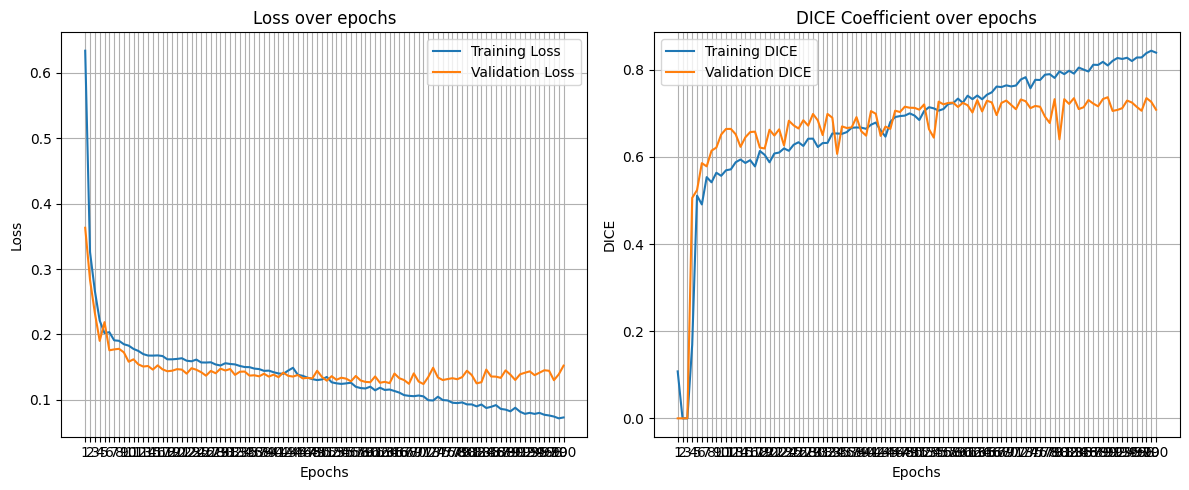

In [ ]:
epochs_list = list(range(1, epochs + 1))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, epochs+1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, epochs+1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.tight_layout()
plt.legend()

plt.show()

# Test

In [ ]:
model_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohort1MultiplexUNet.pth'
trained_model = UNet(in_channels = 3, num_classes = 1).to(device)
trained_model.load_state_dict(torch.load(model_path, map_location = torch.device(device)))

<All keys matched successfully>

In [ ]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
  for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = trained_model(img)
    loss = criterion(y_pred , mask)
    dc = dice_coefficient(y_pred, mask)

    test_running_loss += loss.item()
    test_running_dc += dc.item()

  test_loss = test_running_loss / (idx + 1)
  test_dc = test_running_dc / (idx + 1)

100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


In [ ]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test DICE: {test_dc:.4f}')

Test Loss: 0.1694
Test DICE: 0.6985


In [ ]:
def random_image_inference(image_tensor, mask_tensor, image_paths, model_path, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    for img_tensor, mask_tensor_item, img_path in zip(image_tensor, mask_tensor, image_paths):
        img = img_tensor.to(device)
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1, 2, 0)


        mask = mask_tensor_item.permute(1, 2, 0).to(device)


        dice = dice_coefficient(pred_mask.cpu(), mask.cpu())
        print(f'Image: {os.path.basename(img_path)}, DICE coefficient: {round(float(dice),5)}')

        img_disp = img.cpu().detach().permute(1, 2, 0)
        pred_mask_disp = pred_mask.cpu().detach()
        pred_mask_disp[pred_mask_disp < 0] = 0
        pred_mask_disp[pred_mask_disp > 0] = 1


        plt.figure(figsize=(5,7))
        plt.subplot(131), plt.imshow(img_disp), plt.title("Original Image")
        plt.subplot(132), plt.imshow(pred_mask_disp.squeeze(), cmap='gray'), plt.title("Predicted Mask")
        plt.subplot(133), plt.imshow(mask.cpu().squeeze(), cmap='gray'), plt.title("Mask")
        plt.show()

**Load Some Random Images**

In [ ]:
n = 10
image_tensors = []
mask_tensors = []
image_paths = []

original_dataset = HippocampalDataset(root_path)


for i in range(n):
  random_index = random.randint(0, len(test_dataloader.dataset) - 1)

  original_index = test_dataloader.dataset.indices[random_index]
  random_sample = test_dataloader.dataset[random_index]

  image_tensors.append(random_sample[0])
  mask_tensors.append(random_sample[1])

  image_paths.append(original_dataset.images[original_index])

Image: 10.2dg-5_2.tif, DICE coefficient: 0.88981


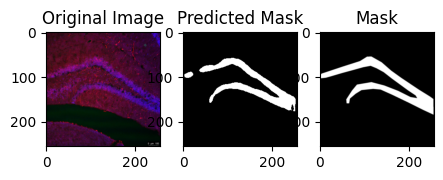

Image: 15.2dg-20_2.tif, DICE coefficient: 0.21221


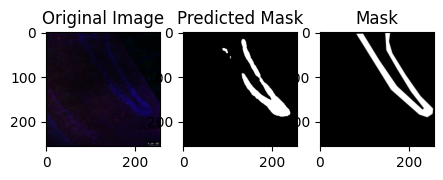

Image: 14ca3-15_2.tif, DICE coefficient: 0.64605


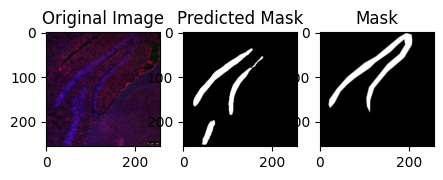

Image: 14dg-12_2.tif, DICE coefficient: 0.48776


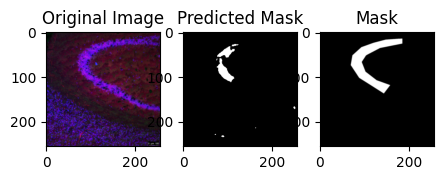

Image: 14ca3-8_2.tif, DICE coefficient: 0.80162


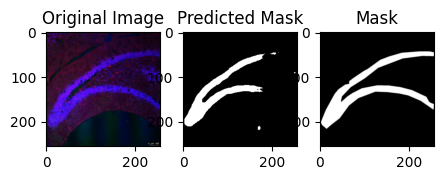

Image: 14ca3-12_2.tif, DICE coefficient: 0.89134


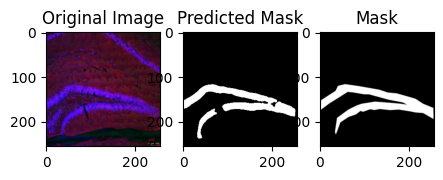

Image: 10dg-12_2.tif, DICE coefficient: 0.71386


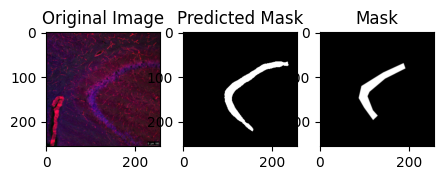

Image: 1.2ca3-4_2.tif, DICE coefficient: 0.58367


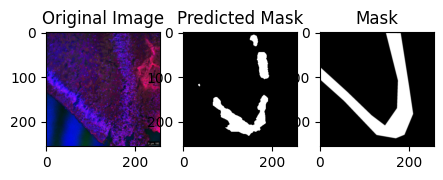

Image: 14ca3-8_2.tif, DICE coefficient: 0.80162


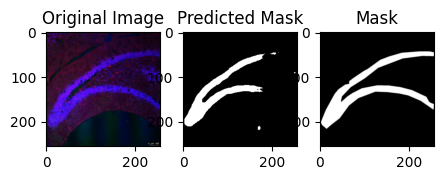

Image: 10ca3-12_2.tif, DICE coefficient: 0.7325


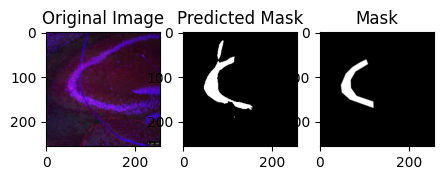

In [ ]:
random_image_inference(image_tensors, mask_tensors, image_paths, model_path, device='cpu')